In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sc
from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import freqs
from scipy import signal
import copy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [414]:

'''_____Standard imports_____'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy import signal
import copy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

def load_data(dir):

    data = []
    file = open(dir,'r')
    for line in file:
        data.append(float(line))
    return data


def butter_highpass(cutoff, fs, order=5):

    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order,
                         normal_cutoff,
                         btype='high',
                         analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):

    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


def make_poly_fit(x=[],y=[], order = 5):

    coefs = np.polynomial.polynomial.polyfit(x, y, order)
    ffit = np.poly1d(coefs[::-1])
    return ffit


def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


def hilbert(data):
    tmp = np.fft.fft(data)
    tmp[0: len(tmp)//2] = 0
    return np.fft.fft(tmp)

def unwrap_phase(spectra):

    spectra = np.array(spectra)
    fft_spectra = hilbert(spectra)
    phase = np.angle( fft_spectra )
    unwrapped_phase = np.unwrap( phase )
    phase[0] = 0
    return unwrapped_phase


def get_phase(spectra):

    Phase = unwrap_phase(spectra)
    return Phase

def apodization(spectra):

    hanning = np.hanning( len(spectra) )
    spectra = hanning*  spectra

    return spectra


def spectra2aline(spectra):

    tmp0 = np.fft.fft(spectra)
    tmp1 = np.fft.fftshift( tmp0 )

    return np.abs( tmp1 )


def linearize_spectra(spectra, x_klinear):

    x = np.arange( len(spectra) )
    phase = get_phase(spectra)

    interpolation = interp1d(x, spectra)
    klinear_spectra = interpolation(x_klinear)


    return klinear_spectra


def compensate_dispersion(spectra, Pdispersion):

    j = complex(0,1)

    tmp = np.real( hilbert(spectra) * np.exp( j * np.array(Pdispersion)  ) )

    return tmp


def k_linearization(spectra1, spectra2):

    phase1 = get_phase(spectra1)
    phase2 = get_phase(spectra2)

    x = np.arange( len(phase1) )
    Plin = (phase1 + phase2) / 2

    fit_x = make_poly_fit( x=Plin, y = x, order = 6 )
    x_klinear = fit_x( np.linspace( Plin[0], Plin[-1], len(Plin) ) )

    interpolated_spectra1 = linearize_spectra(spectra1, x_klinear)
    interpolated_spectra2 = linearize_spectra(spectra2, x_klinear)


    return x_klinear, interpolated_spectra1, interpolated_spectra2


def shift_spectra(spectra1, spectra2, N_pad, plot=True):


    L = len(spectra1)
    x = np.arange( L )
    j = complex(0,1)

    z_space = np.linspace(-np.pi, np.pi, L * N_pad)
    z_space = z_space[len(z_space)//2:-1]

    ff1 = np.abs( np.fft.fftshift( np.fft.fft(spectra1, L * N_pad ) ) )
    ff2 = np.abs( np.fft.fftshift( np.fft.fft(spectra2, L * N_pad ) ) )

    ff1 = ff1[len(ff1)//2:-1]
    ff2 = ff2[len(ff2)//2:-1]

    p0 = [1., 0., 1.]

    coeff1, var_matrix1 = curve_fit(gauss, z_space, ff1, p0=p0)
    coeff2, var_matrix2 = curve_fit(gauss, z_space, ff2, p0=p0)

    if plot:

        fig = plt.figure(figsize=(15, 6))
        ax0 = fig.add_subplot(141)
        ax1 = fig.add_subplot(142)
        ax2 = fig.add_subplot(143)
        ax3 = fig.add_subplot(144)

        ax0.plot(ff1)
        ax1.plot( gauss(z_space, *coeff1) )
        ax2.plot(ff2)
        ax3.plot( gauss(z_space, *coeff2) )

        print("click the image to exit")
        plt.waitforbuttonpress()
        plt.close()


    x_shift = ( coeff1[1] + coeff2[1])/2

    c1 = ( -coeff1[1] + x_shift )
    c2 = ( -coeff2[1] + x_shift )

    shifted_spectra1 = np.real( hilbert(spectra1) * np.exp(j * x * c1 ) )
    shifted_spectra2 = np.real( hilbert(spectra2) * np.exp(j * x * c2 ) )


    return z_space, shifted_spectra1, shifted_spectra2, c1, c2



def compute_dispersion(spectra1, spectra2, c1, c2, plot=True):

    j = complex(0,1)
    x = np.arange( len(spectra1) )

    p1 = unwrap_phase(spectra1) + np.arange(len(spectra2))*c1
    p2 = unwrap_phase(spectra2) + np.arange(len(spectra2))*c2

    Pdisp = (p1-p2)/2
    fit_disp = make_poly_fit( x = x, y = Pdisp, order = 7 )

    Pdispersion = fit_disp(x)
    Pdispersion = Pdispersion - Pdispersion[0]

    compensated_spectra1 = compensate_dispersion(spectra1, -Pdispersion)
    compensated_spectra2 = compensate_dispersion(spectra2, Pdispersion)


    if plot:
        fig = plt.figure(figsize=(15, 6))
        ax0 = fig.add_subplot(111)


        ax0.plot(Pdispersion)
        ax0.set_ylabel('Unwrapped phase [U.A]')
        ax0.set_title('System phase dispersion')
        plt.grid()
        plt.waitforbuttonpress()
        plt.close()

    return compensated_spectra1, compensated_spectra2, Pdispersion


def dB_plot(data1, data2=None):

    fig = plt.figure(figsize=(15, 6))

    if data2 is None:
        ax = fig.add_subplot(111)
        ref1 = np.min(data1)
        dB1 = 10 * np.log(data1/ref1)
        ax.plot(dB1)
        ax.grid()
        ax.set_ylabel('Magnitude [dB]')
        ax.set_xlabel('Wavenumber k [U.A]')

    else:
        ax0 = fig.add_subplot(121)
        ax1 = fig.add_subplot(122)

        ref1 = np.min(data1)
        ref2 = np.min(data1)

        dB1 = 10 * np.log(data1/ref1)
        dB2 = 10 * np.log(data2/ref2)

        ax0.plot(dB1)
        ax0.grid()
        ax0.set_ylabel('Magnitude [dB]')
        ax0.set_xlabel('Wavenumber k [U.A]')

        ax1.plot(dB2)
        ax1.grid()
        ax1.set_ylabel('Magnitude [dB]')
        ax1.set_xlabel('Wavenumber k [U.A]')

    plt.waitforbuttonpress()
    plt.close()


In [3]:

'''_____Standard imports_____'''
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sc
from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import freqs
from scipy import signal
import copy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

'''_____Project imports_____'''
from tools import *


class Spectra(object):


    def __init__(self, data_dir, background_dir = None, ref_dir = None, sample_dir = None):

        self.data_dir = data_dir
        self.background_dir = background_dir
        self.ref_dir = ref_dir
        self.sample_dir = sample_dir


    def load_data(self):

        self.raw = []
        file = open(self.data_dir,'r')
        for line in file:
            self.raw.append(float(line))

        self.raw = np.array(self.raw)


    def get_phase(self):

        self.phase = unwrap_phase(self.raw)
        self.phase[0] = 0


    def plot_phase(self):

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.phase)
        ax.set_ylabel('Phase [rad]')
        ax.set_xlabel('Points space [U.A]')
        plt.grid()
        plt.waitforbuttonpress()
        plt.close()


    def process_data(self):

        self.sub_background()
        self.sub_sample()
        self.sub_ref()
        self.raw = butter_highpass_filter(self.raw,
                                          cutoff=0.8,
                                          fs=30,
                                          order=4)

        self.raw = apodization(self.raw)
        self.get_phase()


    def sub_background(self):

        background = load_data(self.background_dir)

        self.raw = self.raw + background


    def sub_sample(self):

        sample = load_data(self.sample_dir)

        self.raw = self.raw - sample


    def sub_ref(self):

        ref = load_data(self.ref_dir)

        self.raw = self.raw - ref


In [4]:

'''_____Standard imports_____'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
from scipy import signal
import copy
import json
from scipy.interpolate import interp1d


'''_____Project imports_____'''
from tools import *
from PySpectra import Spectra


print('test')
Mirror1 = Spectra(data_dir="data/mirror-.txt",
                  background_dir="data/dark_not.txt",
                  sample_dir = "data/dark_sample.txt",
                  ref_dir = 'data/dark_ref.txt')

Mirror1.load_data()
Mirror1.process_data()
Mirror1.get_phase()
#Mirror1.plot_phase()
print('test')

Mirror2 = Spectra(data_dir="data/mirror+.txt",
                  background_dir="data/dark_not.txt",
                  sample_dir = "data/dark_sample.txt",
                  ref_dir = 'data/dark_ref.txt')

Mirror2.load_data()
Mirror2.process_data()
Mirror2.get_phase()
#Mirror2.plot_phase()

x_new, interpolated_spectra1, interpolated_spectra2 = k_linearization(Mirror1.raw,
                                                                      Mirror2.raw)


z_space, shifted_spectra1, shifted_spectra2, c1, c2 = shift_spectra(interpolated_spectra1,
                                                                    interpolated_spectra2,
                                                                    N_pad=10,
                                                                    plot=False)

spectra1, spectra2, Pdispersion = compute_dispersion(shifted_spectra1,
                                                     shifted_spectra2,
                                                     c1,
                                                     c2,
                                                     plot=False)

#dB_plot(spectra2aline(spectra1), spectra2aline(Mirror1.raw))
#dB_plot(spectra2aline(spectra2), spectra2aline(Mirror2.raw))

print(len(Mirror1.raw))
print(np.max(x_new))
calib_dict = {"klinear":     list(x_new),
              "dispersion":  list(Pdispersion),
              "dark_not":    load_data("data/dark_not.txt"),
              "dark_ref":    load_data("data/dark_ref.txt"),
              "dark_sample": load_data("data/dark_sample.txt")
              }

with open('calibration_parameters.json', 'w') as outfile:
    json.dump(calib_dict, outfile)




test
test


/usr/local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


1024
982.4725827822305


In [ ]:
Mirror1

In [5]:
x_new, interpolated_spectra1, interpolated_spectra2 = k_linearization(Mirror1.raw, 
                                                                      Mirror2.raw)



In [6]:
z_space, shifted_spectra1, shifted_spectra2, c1, c2 = shift_spectra(interpolated_spectra1, 
                                                                    interpolated_spectra2, 
                                                                    N_pad=10,
                                                                    plot=False)

In [7]:
spectra1, spectra2, Pdispersion = compute_dispersion(shifted_spectra1, 
                                                     shifted_spectra2, 
                                                     c1, 
                                                     c2,
                                                     plot=False)


In [ ]:
dB_plot(spectra2aline(spectra1), spectra2aline(Mirror1.raw))

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


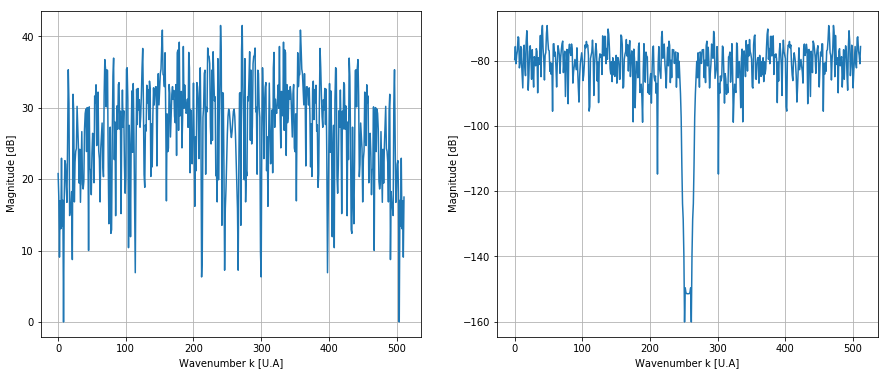

In [189]:
dB_plot(spectra2aline(spectra2), spectra2aline(Mirror2.raw))

In [190]:
import lzma
import numpy as np
import binascii
import struct
import matplotlib.pyplot as plt
filename = '/Users/macbooklodi/Desktop/Biophotonic/Biophotonic/Doc_project/dispersion/data/Bscan/orange_1.txt'

file = open(filename, 'r')
data = []

for line in file:
    data.append( line  )




In [479]:
N = len(data)
aline = []
raw_aline = []

for i in range(0,N):
    
    spectra = data[i].split('\t')
    spectra = list( map(float, spectra) )
    raw_aline.append(spectra2aline(spectra))
    
    tmp = apodization(spectra)
    tmp = linearize_spectra(tmp, x_new)
    tmp = compensate_dispersion(tmp, -Pdispersion)
    tmp = spectra2aline(tmp)
    
    aline.append(tmp)
    
    
NN = 400
dB_plot(aline[NN], raw_aline[NN])

AttributeError: 'int' object has no attribute 'split'

In [493]:

def load_Bscan_spectra(file_dir, block_start=276, block_end = 632084, shape1=617, shape2=1024):
    
    data = np.fromfile(file_dir, dtype = np.uint16)
    block_data = data[block_start: block_end]
    Bscan_spectra = block_data.reshape([617,1024])
    return Bscan_spectra


def process_Bscan(Bscan_spectra):
    
    Bscan = []
    for i, spectra in enumerate(Bscan_spectra):

        spectra = np.array(spectra)  - np.array(calibration['dark_not']) - np.array(calibration['dark_ref']) + np.array(calibration['dark_sample'])
        spectra = apodization(spectra)
        spectra = butter_highpass_filter(spectra,
                                          cutoff=0.001,
                                          fs=30,
                                          order=4)
        spectra = linearize_spectra(spectra, calibration['klinear'])
        spectra = compensate_dispersion(np.array(spectra), np.array(calibration['dispersion']) )
        Aline = spectra2aline(spectra)
        Aline = Aline[0:len(Aline)//2]
        Bscan.append(Aline)
    

    return Bscan
    
  
file = '/Users/macbooklodi/Desktop/Biophotonic/Biophotonic/Doc_project/dispersion/data/Bscan/orange_1.raw'

Bscan_spectra = load_Bscan_spectra(file)

Bscan = process_Bscan(Bscan_spectra)

/usr/local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


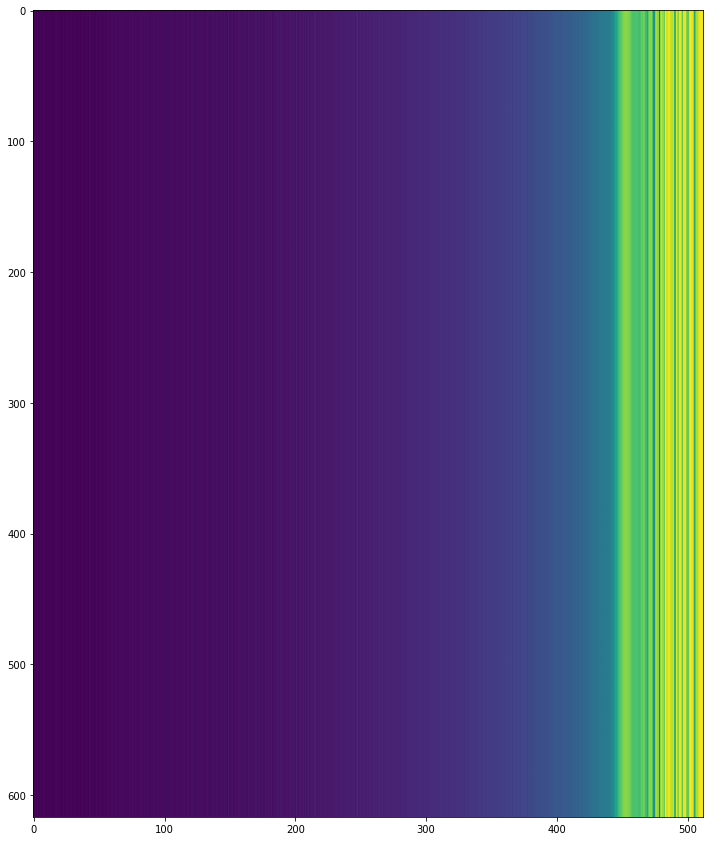

In [494]:
fig = plt.figure(figsize=(12,15))
plt.imshow(np.log(Bscan))


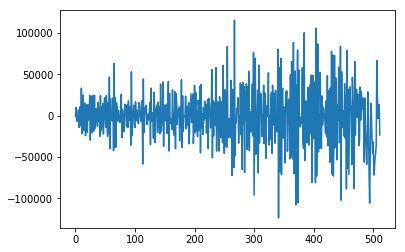

In [504]:
plt.plot(Bscan[50]-Bscan[51])